# Decision Trees for Regression

Decision trees are capable of finding complex non linear relationships in the data. They can perform both classification and regression tasks. In this notebook, we will demonstrate decision trees for regression tasks with california housing dataset and `DecisionTreeRegressor` class in `sklearn.tree` module.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(69)

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree

Let's use `ShuffleSplit` as a cross validator with $10$ splits and $20\%$ of examples set aside as test examples.

In [3]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=69)

# Loading the dataset

In [4]:
# fetch dataste
from sklearn.datasets import fetch_california_housing
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train test split
from sklearn.model_selection import train_test_split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=69)

# train --> train + dev (validation)
X_train, X_dev, y_train, y_dev = train_test_split(com_train_features, com_train_labels, random_state=69)

# Model Setup

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

dt_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=69))
])

dt_reg_cv_results = cross_validate(
    dt_reg_pipeline,
    com_train_features, com_train_labels,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f"Mean Absolute Error of Decision Tree Regressor on train set:\n"f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std()}")
print(f"Mean Absolute Error of Decision Tree Regressor on test set:\n"f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std()}")

Mean Absolute Error of Decision Tree Regressor on train set:
0.592 +/- 0.0044067553291434955
Mean Absolute Error of Decision Tree Regressor on test set:
0.598 +/- 0.009395359038405493


# Visualization

One of the advantages of using a decision tree regressor/classifier is that the output is inuitive to understand and can be easily visualized.

This can be done in $2$ ways:
- As a tree diagram
- As a text based diagram

## 1. Tree Diagram

We need to call `fit` function on `pipeline` object before printing the tree.

In [7]:
dt_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=69))])

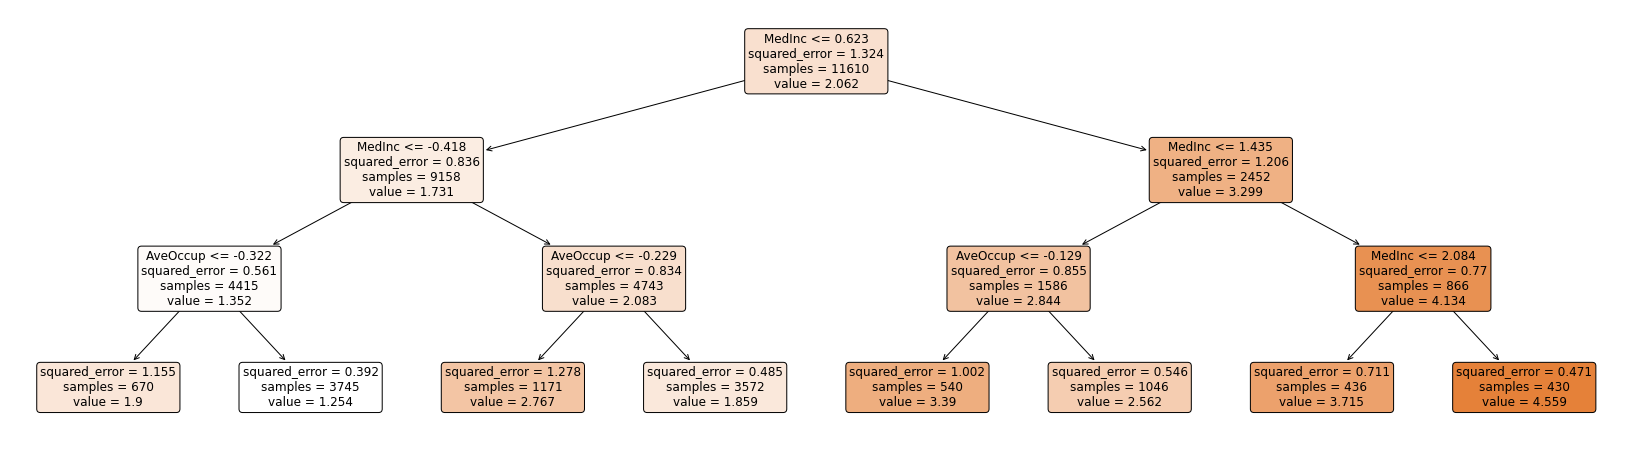

In [10]:
from sklearn.tree import plot_tree

plt.figure(figsize=(29,8), facecolor='w')
plot_tree(
    dt_reg_pipeline[-1],
    feature_names=features.columns,
    rounded=True,
    filled=True,
    fontsize=12
)
plt.show()

## 2. Text Based Diagram

In [11]:
from sklearn.tree import export_text

# Export the decision rules
tree_rules = export_text(
    dt_reg_pipeline[-1]
)
# Print the results
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.42
|   |   |--- feature_5 <= -0.32
|   |   |   |--- value: [1.90]
|   |   |--- feature_5 >  -0.32
|   |   |   |--- value: [1.25]
|   |--- feature_0 >  -0.42
|   |   |--- feature_5 <= -0.23
|   |   |   |--- value: [2.77]
|   |   |--- feature_5 >  -0.23
|   |   |   |--- value: [1.86]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.44
|   |   |--- feature_5 <= -0.13
|   |   |   |--- value: [3.39]
|   |   |--- feature_5 >  -0.13
|   |   |   |--- value: [2.56]
|   |--- feature_0 >  1.44
|   |   |--- feature_0 <= 2.08
|   |   |   |--- value: [3.72]
|   |   |--- feature_0 >  2.08
|   |   |   |--- value: [4.56]



# Evaluation

We first use the decision tree to make predictions.

In [12]:
test_labels_hat = dt_reg_pipeline.predict(test_features)

Now, we evaluate the tree regressor using various evaluation metrics.

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_labels, test_labels_hat)
mse = mean_squared_error(test_labels, test_labels_hat)
r2 = r2_score(test_labels, test_labels_hat)

print("The model performance for testing set :")
print("MAE = ", mae)
print("MSE = ", mse)
print("R2 Score = ", r2)

The model performance for testing set :
MAE =  0.6005245624326975
MSE =  0.6319673181325306
R2 Score =  0.5310734390324174


# Hyperparameter Tuning

We will now try to improve the model by tuning the hyperparameters.

We will be using `GridSearchCV` to accomplish this.

In [16]:
from sklearn.model_selection import GridSearchCV

dt_reg_param = {
    'dt_reg__max_depth': range(1,20),
    'dt_reg__min_samples_split':range(2,12,2)
}

gs_dt_reg = GridSearchCV(
    dt_reg_pipeline,
    param_grid=dt_reg_param,
    n_jobs=2,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
)

In [17]:
gs_dt_reg.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=69, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=69))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 12, 2)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [18]:
mean_train_error = -1 * gs_dt_reg.cv_results_['mean_train_score'][gs_dt_reg.best_index_]
mean_test_error = -1 * gs_dt_reg.cv_results_['mean_test_score'][gs_dt_reg.best_index_]
std_train_error = -1 * gs_dt_reg.cv_results_['std_train_score'][gs_dt_reg.best_index_]
std_test_error = -1 * gs_dt_reg.cv_results_['std_test_score'][gs_dt_reg.best_index_]

print(f"Mean Absolute Error of Decision Tree Regressor on train set:\n"f"{mean_train_error:.3f} +/- {std_train_error}")
print(f"Mean Absolute Error of Decision Tree Regressor on test set:\n"f"{mean_test_error:.3f} +/- {std_test_error}")

Mean Absolute Error of Decision Tree Regressor on train set:
0.284 +/- -0.005041621096017114
Mean Absolute Error of Decision Tree Regressor on test set:
0.419 +/- -0.011366164652144427


In [19]:
print("Mean cross validated score of the best estimator is: ", -1*gs_dt_reg.best_score_)

Mean cross validated score of the best estimator is:  0.41867242990849524


In [20]:
print("The parameters of the best estimator is: ", gs_dt_reg.best_params_)

The parameters of the best estimator is:  {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 10}


Let's retrain the model with best hyperparameters.

In [21]:
best_dt_reg = gs_dt_reg.best_estimator_

best_dt_reg.fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=10,
                                       random_state=69))])

In [22]:
test_labels_hat = best_dt_reg.predict(test_features)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_labels, test_labels_hat)
mse = mean_squared_error(test_labels, test_labels_hat)
r2 = r2_score(test_labels, test_labels_hat)

print("The model performance for testing set :")
print("MAE = ", mae)
print("MSE = ", mse)
print("R2 Score = ", r2)

The model performance for testing set :
MAE =  0.4165013214771206
MSE =  0.4010249647652525
R2 Score =  0.7024351541702994


We can see a significant improvement in performance already.